# Лабораторна робота №1

In [1]:
!export CUDA_VISIBLE_DEVICES=1

In [2]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import plotly.express as px
import splitfolders
import cv2
import seaborn as sns


# Перевіряємо доступні GPU
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Вибираємо потрібний GPU і дозволяємо динамічне виділення пам'яті
tf.config.set_visible_devices(gpus[1], 'GPU')  # або 0
tf.config.experimental.set_memory_growth(gpus[1], True)

print("Using GPU:", gpus[1])

2025-09-25 23:43:26.887228: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Using GPU: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


### Налаштування

>Перед початком скачати [датасет](https://www.kaggle.com/datasets/parnianmalekian/rice-image-classification) і завантажити в папку `/data`

In [3]:
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

rootPath = '../data/Rice_Image_Dataset'
out_dir = "../data/rice_imgs"

TensorFlow: 2.20.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


### Перевірка класів

In [4]:
class_names = sorted([d for d in os.listdir(rootPath) if os.path.isdir(os.path.join(rootPath, d))])
sizes = [len(os.listdir(os.path.join(rootPath, name))) for name in class_names]
print("Класи:", class_names)
print("К-сть зображень по класах:", sizes)

fig = px.pie(
    names=class_names,
    values=sizes,
    width=500,
    title='Розподіл класів (Rice Image Dataset)',
    hole=0.4
)
fig.update_layout({'title': {'x': 0.5}})
fig.show()

Класи: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
К-сть зображень по класах: [15000, 15000, 15000, 15000, 15000]


### Випадкові зображення

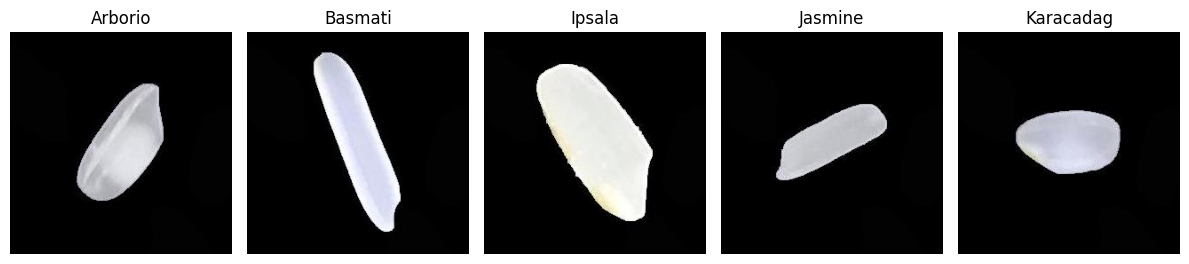

In [5]:
def load_random_img(dir_path, labels, n_cols=5):
    plt.figure(figsize=(12, 6))
    for i, label in enumerate(labels[:n_cols], 1):
        file = random.choice(os.listdir(os.path.join(dir_path, label)))
        image_path = os.path.join(dir_path, label, file)
        img = cv2.imread(image_path)[:, :, ::-1]  # BGR->RGB
        plt.subplot(1, n_cols, i)
        plt.title(label)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

load_random_img(rootPath, class_names)

### Розділення даних

In [6]:
if not os.path.exists(out_dir) or not os.path.isdir(os.path.join(out_dir, "train")):
    splitfolders.ratio(rootPath, output=out_dir, seed=SEED, ratio=(.7, .15, .15))

batch_size = 128
img_height, img_width = 256, 256
input_shape = (img_height, img_width, 3)
AUTOTUNE = tf.data.AUTOTUNE


from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
print("Image data format:", K.image_data_format())  # має бути 'channels_last'

Image data format: channels_last


### Підготовка датасетів

In [7]:
def prepare_dataset(subset):
    ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(out_dir, subset),
        labels='inferred',
        label_mode='categorical',
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=(subset=='train'),
        seed=SEED
    )
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = prepare_dataset('train')
val_ds = prepare_dataset('val')
test_ds = prepare_dataset('test')

Found 52500 files belonging to 5 classes.


I0000 00:00:1758833015.621155  165921 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10392 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 11250 files belonging to 5 classes.
Found 11250 files belonging to 5 classes.


In [8]:
def build_cnn(input_shape=(256, 256, 3), n_classes=5):
    model = Sequential([
         # очікує зображення 256x256x3
        Input(shape=input_shape),

        # --- Перший блок ---
        Conv2D(32, 3, activation='relu', padding='same'),  # Згортка 3x3, 32 фільтри
        MaxPooling2D(2),  # Зменшення розмірності вдвічі
        BatchNormalization(),  # Нормалізація для стабілізації навчання

        # --- Другий блок ---
        Conv2D(64, 3, activation='relu', padding='same'), # Згортка 3x3, 64 фільтри
        MaxPooling2D(2),
        BatchNormalization(),

        # --- Третій блок ---
        Conv2D(128, 3, activation='relu', padding='same'), # Згортка 3x3, 128 фільтри
        MaxPooling2D(2),
        Dropout(0.3),  # dropout щоб не мати overfitting

        # --- Перетворення в вектор ---
        Flatten(),  # Згортковий вихід перетворюється у одномірний вектор

        # --- Fully connected layers ---
        Dense(256, activation='relu'),
        Dropout(0.4),  # хелпує уникнути overfitting на Dense шарах
        Dense(n_classes, activation='softmax')  # Вихідний шар для класифікації n_classes
    ])
    return model

n_classes = train_ds.element_spec[1].shape[-1]
CNN = build_cnn(input_shape=(img_height, img_width, 3), n_classes=n_classes)
CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
CNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,649,605 (128.36 MB)

 Trainable params: 33,649,413 (128.36 MB)

 Non-trainable params: 192 (768.00 B)

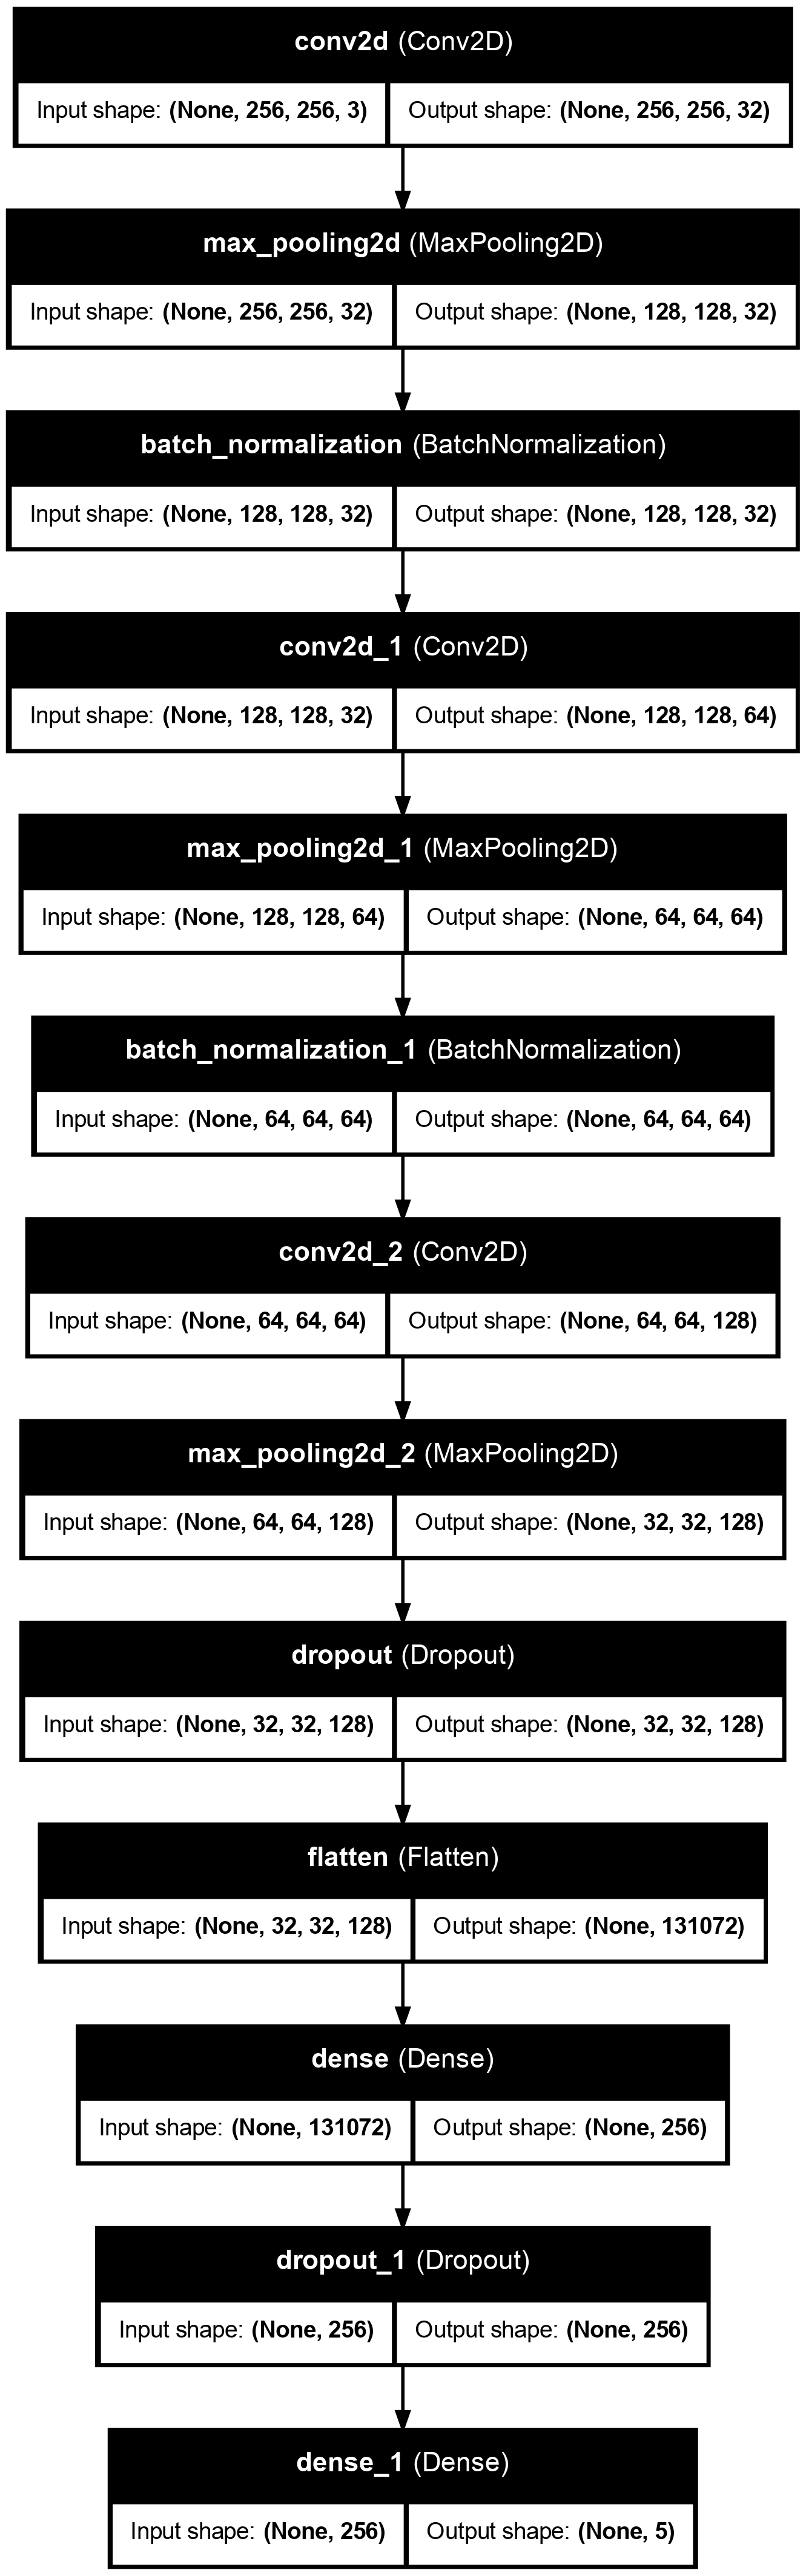

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(
    CNN,
    to_file='cnn_model.png',
    show_shapes=True,         # показує розміри тензорів після кожного шару
    show_layer_names=True,    # показує назви шарів
    rankdir='TB',             # напрямок Top-Bottom (можна 'LR' для Left-Right)
    expand_nested=False
)

In [9]:
# Callbacks
ckpt_path = "best_cnn.keras"
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True)
]

# Training
EPOCHS = 11
history = CNN.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/11
411/411 ━━━━━━━━━━━━━━━━━━━━ 119s 290ms/step - accuracy: 0.7126 - loss: 4.5743 - val_accuracy: 0.5135 - val_loss: 7.7805
Epoch 2/11
411/411 ━━━━━━━━━━━━━━━━━━━━ 116s 283ms/step - accuracy: 0.7640 - loss: 3.7928 - val_accuracy: 0.4459 - val_loss: 8.9224
Epoch 3/11
411/411 ━━━━━━━━━━━━━━━━━━━━ 120s 291ms/step - accuracy: 0.7200 - loss: 4.5063 - val_accuracy: 0.7121 - val_loss: 4.6336
Epoch 4/11
411/411 ━━━━━━━━━━━━━━━━━━━━ 116s 282ms/step - accuracy: 0.7003 - loss: 4.8247 - val_accuracy: 0.4812 - val_loss: 8.3585
Epoch 5/11
411/411 ━━━━━━━━━━━━━━━━━━━━ 116s 282ms/step - accuracy: 0.6438 - loss: 5.7373 - val_accuracy: 0.5679 - val_loss: 6.9641
Epoch 6/11
411/411 ━━━━━━━━━━━━━━━━━━━━ 116s 283ms/step - accuracy: 0.6859 - loss: 5.0594 - val_accuracy: 0.6876 - val_loss: 5.0322


### Оцінка

In [10]:
loss, acc = CNN.evaluate(test_ds, verbose=1)
print(f"Test loss: {loss:.4f}, Test accuracy: {acc*100:.2f}%")

88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.7053 - loss: 4.7436
Test loss: 4.7436, Test accuracy: 70.53%


### Звіти

88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step
Classification Report:
               precision    recall  f1-score   support

     Arborio       0.87      0.75      0.81      2250
     Basmati       0.47      1.00      0.64      2250
      Ipsala       1.00      0.78      0.88      2250
     Jasmine       0.00      0.00      0.00      2250
   Karacadag       0.81      0.99      0.89      2250

    accuracy                           0.71     11250
   macro avg       0.63      0.71      0.64     11250
weighted avg       0.63      0.71      0.64     11250



2025-09-25 23:29:20.525307: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/hdd2/highbrow/deep_learning_technologies/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/hdd2/highbrow/deep_learning_technologies/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/hdd2/highbrow/deep_learning_technologies/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

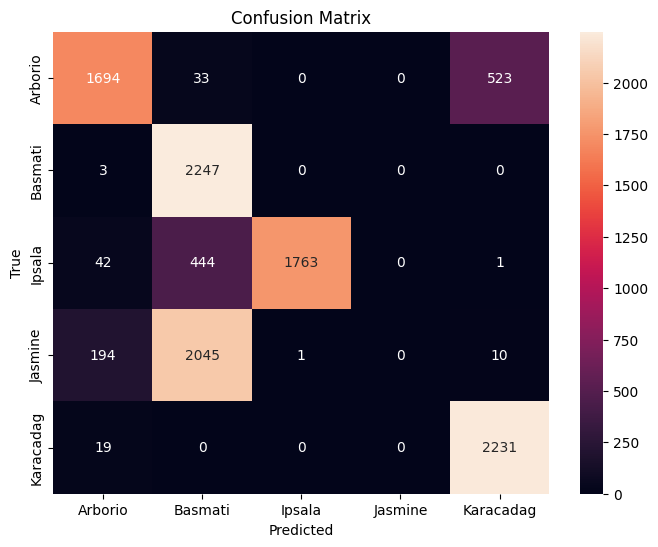

In [11]:
y_pred_proba = CNN.predict(test_ds, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Графік навчання

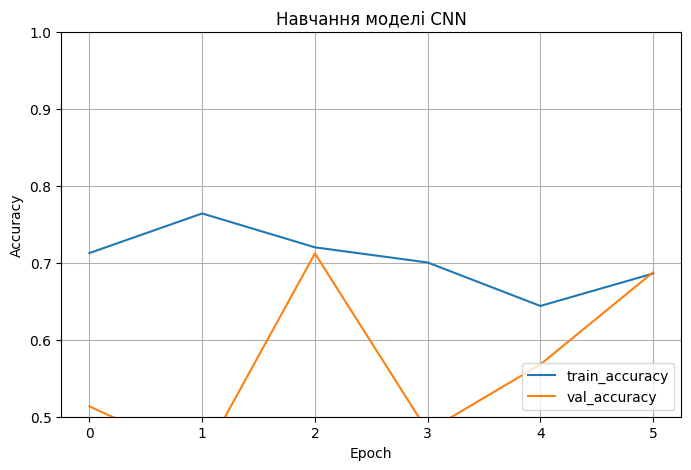

In [17]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.title("Навчання моделі CNN")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Графік втрат

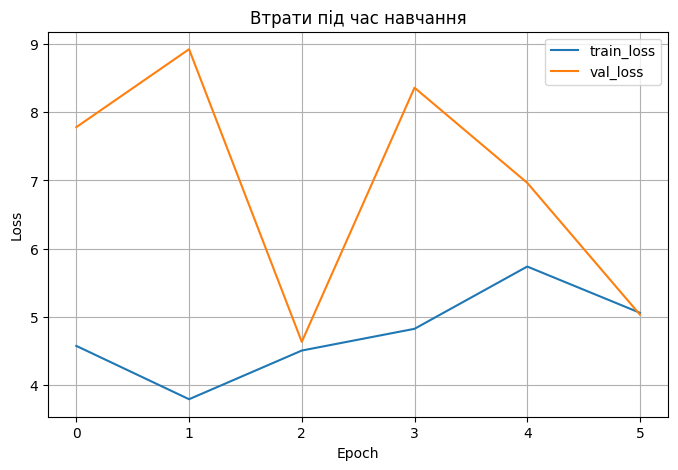

In [18]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Втрати під час навчання")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()